<a href="https://colab.research.google.com/github/Zeko6666/Benchmark-Paddy/blob/main/ResNet101V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import needed modules

In [ ]:
# Importing necessary libraries
import os
import time
import shutil
import itertools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Display a message indicating that modules have been loaded successfully
print('Modules loaded')

Modules loaded


In [ ]:
# Function to generate filepaths and labels from the provided directory
def define_paths(dir):
    filepaths = []
    labels = []

    # List all the folders (categories) in the given directory
    folds = os.listdir(dir)

    # Iterate through each folder
    for fold in folds:
        foldpath = os.path.join(dir, fold)

        # List all the files in the current folder
        filelist = os.listdir(foldpath)

        # Iterate through each file in the folder
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)  # Assign the folder name (class label) to each file

    return filepaths, labels

# Function to create a DataFrame from the generated filepaths and labels
def define_df(files, classes):
    Fseries = pd.Series(files, name='filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis=1)

# Function to split the data into training, validation, and test sets
def split_data(tr_dir):
    # Generate filepaths and labels
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)

    # Use stratified sampling to ensure proportional representation of each class
    strat = df['labels']
    train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)

    # Further split the remaining data into validation and test sets
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)

    return train_df, valid_df, test_df


In [ ]:
# !kaggle competitions download -c paddy-disease-classification

#### Function to generate images from dataframe

In [ ]:
def create_model_data(train_df, valid_df, test_df, batch_size):
    # Define image properties
    img_size = (224, 224)
    channels = 3  # 3 for RGB color images, 1 for grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Determine batch size for the test data
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # Define a function for scalar preprocessing (identity function)
    def scalar(img):
        return img

    # Create image data generators for training, validation, and testing
    tr_gen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
    ts_gen = ImageDataGenerator(preprocessing_function=scalar)

    # Create data generators for training, validation, and testing
    train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                          target_size=img_size, class_mode='categorical',
                                          color_mode=color, shuffle=True, batch_size=batch_size)

    valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                          target_size=img_size, class_mode='categorical',
                                          color_mode=color, shuffle=True, batch_size=batch_size)

    test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                         target_size=img_size, class_mode='categorical',
                                         color_mode=color, shuffle=False, batch_size=test_batch_size)

    return train_gen, valid_gen, test_gen


#### Function to display data sample

In [ ]:
def show_images(gen):
    # Get class indices and names from the generator
    g_dict = gen.class_indices
    classes = list(g_dict.keys())

    # Retrieve a batch of images and labels from the generator
    images, labels = next(gen)

    # Determine the number of images in the batch
    length = len(labels)
    sample = min(length, 25)  # Display up to 25 images

    # Create a 5x5 grid to display the images
    plt.figure(figsize=(20, 20))

    # Iterate over the images in the batch
    for i in range(sample):
        plt.subplot(5, 5, i + 1)

        # Normalize the image to be in the range [0, 1]
        image = images[i] / 255

        # Display the image
        plt.imshow(image)

        # Get the index of the maximum value in the label (one-hot encoded)
        index = np.argmax(labels[i])

        # Retrieve the class name corresponding to the index
        class_name = classes[index]

        # Display the class name as the title
        plt.title(class_name, color='blue', fontsize=12)

        # Turn off axis labels for better visualization
        plt.axis('off')

    # Show the plot with the images
    plt.show()


In [ ]:
class PaddyCallback(keras.callbacks.Callback):
    def __init__(self, model, base_model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(PaddyCallback, self).__init__()
        self.model = model
        self.base_model = base_model
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.batches = batches
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch

        # Callback variables
        self.count = 0
        self.stop_count = 0
        self.best_epoch = 1
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))
        self.highest_tracc = 0.0
        self.lowest_vloss = np.inf
        self.best_weights = self.model.get_weights()
        self.initial_weights = self.model.get_weights()


    def on_train_begin(self, logs=None):
        # Display header for monitoring training progress
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs=None):
        # Display elapsed time after training completion
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # Set the model weights to the best weights achieved during training
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs=None):
        # Display information about the training progress after each batch
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='')


    def on_epoch_begin(self, epoch, logs=None):
        # Record the start time of the current epoch
        self.ep_start = time.time()


    def on_epoch_end(self, epoch, logs=None):
        # Record the end time of the current epoch
        ep_end = time.time()
        duration = ep_end - self.ep_start

        # Get relevant metrics and parameters for monitoring
        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        current_lr = lr
        acc = logs.get('accuracy')
        v_acc = logs.get('val_accuracy')
        loss = logs.get('loss')
        v_loss = logs.get('val_loss')

        if acc < self.threshold:
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc

            if acc > self.highest_tracc:
                self.highest_tracc = acc
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1

            else:
                if self.count >= self.patience - 1:
                    lr = lr * self.factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                    self.count = 0
                    self.stop_count = self.stop_count + 1
                    self.count = 0
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1

        else:
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss
            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                self.best_epoch = epoch + 1
            else:
                if self.count >= self.patience - 1:
                    lr = lr * self.factor
                    self.stop_count = self.stop_count + 1
                    self.count = 0
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                else:
                    self.count = self.count + 1
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        # Display information about the current epoch
        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        # Check if training should be stopped based on patience
        if self.stop_count > self.stop_patience - 1:
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True


#### Function to plot history of training

In [ ]:
def plot_training(hist):
    # Extract training and validation metrics from the history object
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc1 = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']

    # Adjust validation accuracy for better visualization
    val_acc = [x + 0.012 for x in val_acc1]

    # Find the epoch with the lowest validation loss and the highest validation accuracy
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]

    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    # Create a figure with two subplots for loss and accuracy
    plt.figure(figsize=(20, 8))

    # Plotting Loss
    Epochs = [i + 1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Accuracy
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

#### Function to create Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    # Set up the figure for plotting the confusion matrix
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Set tick marks and labels for the classes on both axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # If normalization is requested, normalize the confusion matrix
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')

    # Display the numerical values in each cell of the confusion matrix
    print(cm)

    # Set a threshold for text color in each cell
    thresh = cm.max() / 2.

    # Display the numerical values as text in each cell with appropriate color
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    # Adjust layout and add labels to the axes
    plt.tight_layout()
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')


# Model Structure

#### Start Reading Dataset

Found 8325 validated image filenames belonging to 10 classes.
Found 1041 validated image filenames belonging to 10 classes.
Found 1041 validated image filenames belonging to 10 classes.


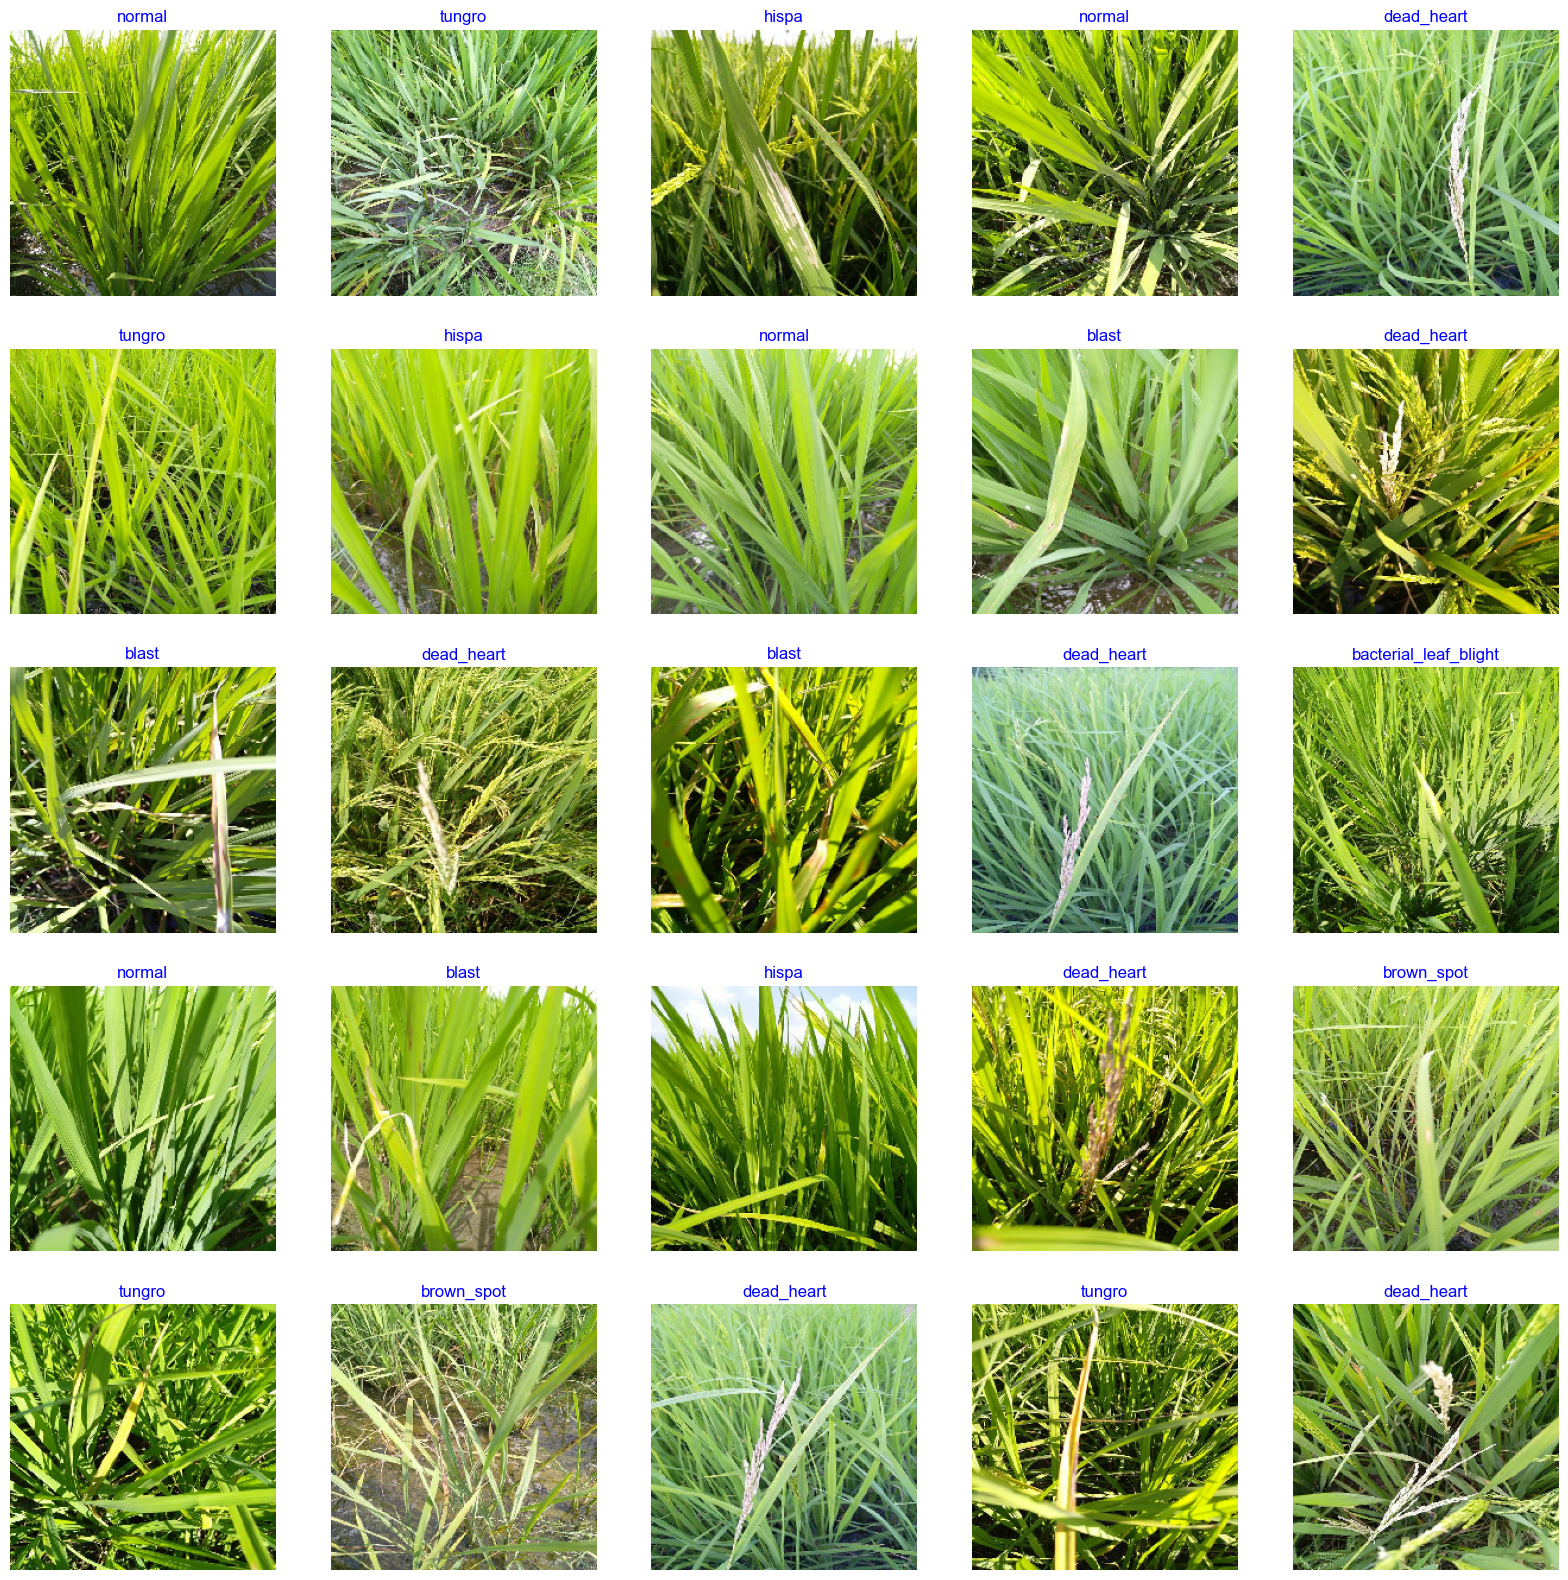

In [ ]:
# Get Dataframes
data_dir = 'C:\\Users\\models\\ModelsTraining\\paddy-disease-classification\\train_images'
train_df, valid_df, test_df = split_data(data_dir)

# Get Generators
batch_size = 32
train_gen, valid_gen, test_gen = create_model_data(train_df, valid_df, test_df, batch_size)

# Display Image Samples
show_images(train_gen)

#### Generic Model Creation

In [ ]:
# Define image properties
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Calculate the number of classes based on the generator's class indices
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained model (ResNet101V2)
base_model = tf.keras.applications.ResNet101V2(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
base_model.trainable = False
# Build the complete model by adding additional layers on top of the pre-trained base model
model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256,
          kernel_regularizer=regularizers.l2(l=0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006),
          activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

# Compile the model with specified optimizer, loss function, and metrics
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display a summary of the model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 2048)              42626560  
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 43,161,866
Trainable params: 531,210
Non-trainable params: 42,630,656
____________________________________

#### Set Callback Parameters

In [ ]:
# Define training parameters
batch_size = 32
epochs = 50
patience = 1
stop_patience = 3
threshold = 0.9
factor = 0.5
ask_epoch = 5

# Calculate the number of batches in the training data
batches = int(np.ceil(len(train_gen.labels) / batch_size))

# Create an instance of the custom callback class with specified parameters
callbacks = [PaddyCallback(model=model, base_model=base_model, patience=patience,
                            stop_patience=stop_patience, threshold=threshold, factor=factor,
                            batches=batches, epochs=epochs, ask_epoch=ask_epoch)]


#### Train model

In [ ]:
# Train the model using the training generator and validation generator
# Apply the custom callbacks defined in the callbacks list during training
history = model.fit(
    x=train_gen,
    epochs=epochs,
    verbose=0,
    callbacks=callbacks,
    validation_data=valid_gen,
    validation_steps=None,
    shuffle=False
)

model.save("model_checkPoints.h5")

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /50     5.122   35.351   3.90491  50.528   0.00100  0.00100  accuracy     0.00   1827.66 
 2 /50     3.461   49.730   3.00734  56.484   0.00100  0.00100  accuracy    40.67   1722.43 
 3 /50     2.748   54.450   2.47094  60.807   0.00100  0.00100  accuracy     9.49   1696.31 
 4 /50     2.298   58.258   2.12616  60.999   0.00100  0.00100  accuracy     6.99   1716.61 
 5 /50     2.031   60.937   1.90880  63.497   0.00100  0.00100  accuracy     4.60   1699.29 
 6 /50     1.863   62.042   1.77335  64.745   0.00100  0.00100  accuracy     1.81   1741.02 
 7 /50     1.732   64.420   1.67574  66.763   0.00100  0.00100  accuracy     3.83   1776.29 
 8 /50     1.643   65.634   1.60315  66.859   0.00100  0.00100  accuracy     1.88   1779.34 
 9 /50     1.573   67.075   1.58417  67.723   0.00100  0.00100  accuracy     2.20   1790.17 
10 /50     1.525   67.351   1.53068  68.204   0.00100  0.00100  accurac

#### Display model performance

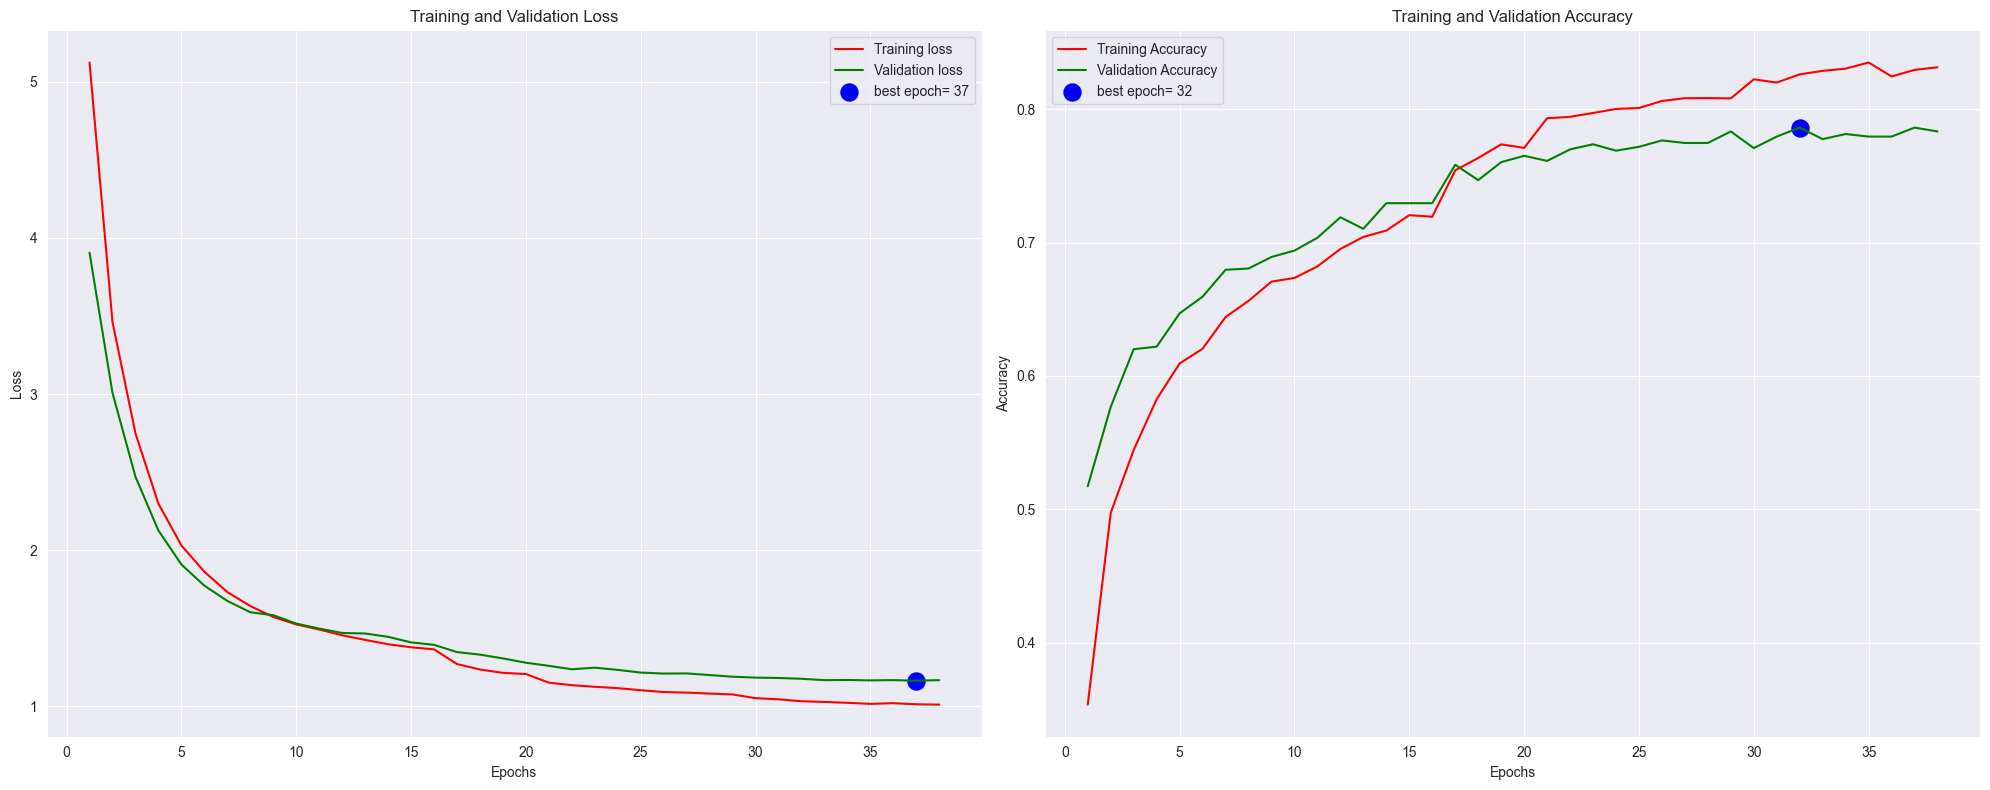

In [ ]:
plot_training(history)

### Evaluate model

In [ ]:
# Calculate the number of batches for testing data
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

# Evaluate the model on the training data
train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)

# Evaluate the model on the validation data
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)

# Evaluate the model on the test data
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

# Display the evaluation results
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

347/347 [==============================] - 233s 671ms/step - loss: 1.1739 - accuracy: 0.7695
Train Loss:  0.8894556760787964
Train Accuracy:  0.889129102230072
--------------------
Validation Loss:  1.1668623685836792
Validation Accuracy:  0.7675312161445618
--------------------
Test Loss:  1.1739354133605957
Test Accuracy:  0.7694524526596069


### Get Predictions

In [ ]:
# Generate predictions using the trained model on the test generator
preds = model.predict_generator(test_gen)

# Get the predicted class indices by selecting the index with the highest probability
y_pred = np.argmax(preds, axis=1)

# Print the predicted class indices
print(y_pred)

[5 6 2 ... 9 5 8]


#### Confusion Matrics and Classification Report

Confusion Matrix, Without Normalization
[[ 22   2   0   4   4   1   0   8   3   4]
 [  0  31   1   3   0   1   0   2   0   0]
 [  0   2  17   2   0  10   0   2   0   0]
 [  1   0   1 143   4   3   3   7   5   7]
 [  1   0   0   8  60   1   0  11   7   9]
 [  0   1   4   5   4 125   0   2   1   2]
 [  2   0   0   6   2   3  39   3   5   2]
 [  1   1   1   6   3   4   0 132   9   3]
 [  1   0   0   6   2   1   2   8 154   2]
 [  1   0   0  10   4   2   1   9   4  78]]
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.76      0.46      0.57        48
   bacterial_leaf_streak       0.84      0.82      0.83        38
bacterial_panicle_blight       0.71      0.52      0.60        33
                   blast       0.74      0.82      0.78       174
              brown_spot       0.72      0.62      0.67        97
              dead_heart       0.83      0.87      0.85       144
            downy_mildew       0.87      0.63      0.73        62


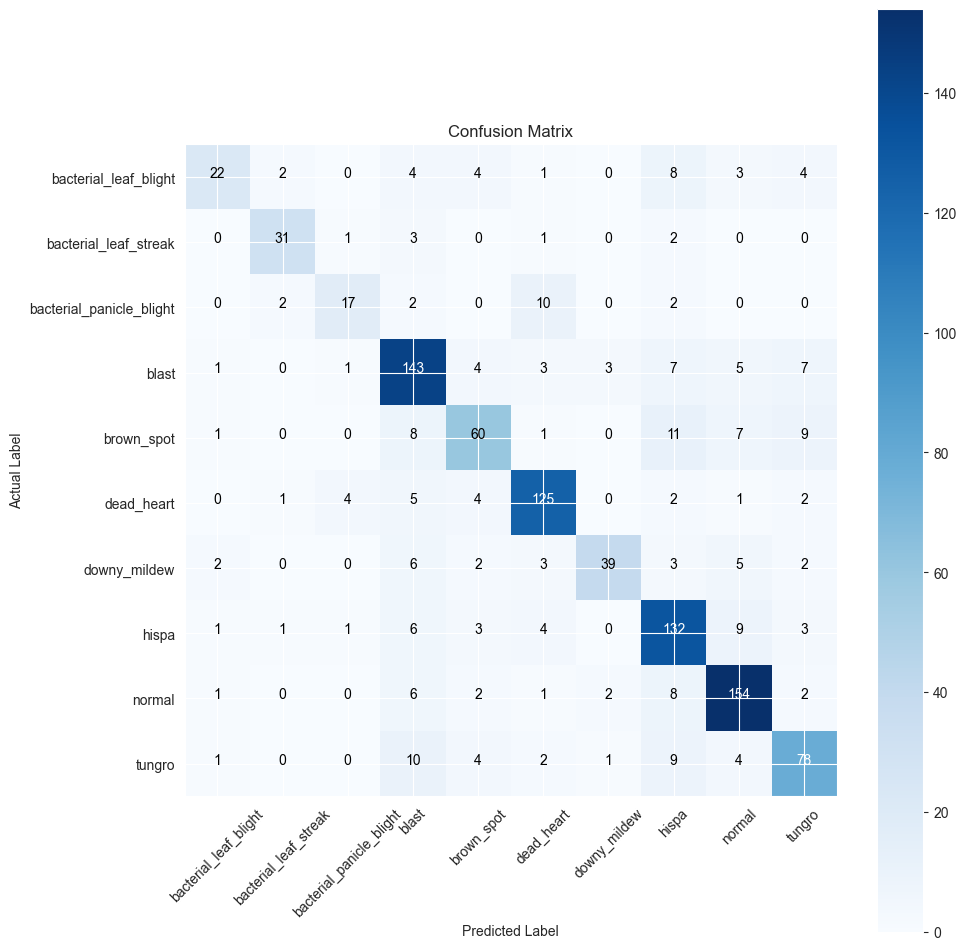

In [ ]:
# Get class indices and names from the test generator
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Create confusion matrix based on true and predicted labels
cm = confusion_matrix(test_gen.classes, y_pred)

# Plot the confusion matrix
plot_confusion_matrix(cm=cm, classes=classes, title='Confusion Matrix')

# Display classification report with precision, recall, and F1-score
print(classification_report(test_gen.classes, y_pred, target_names=classes))


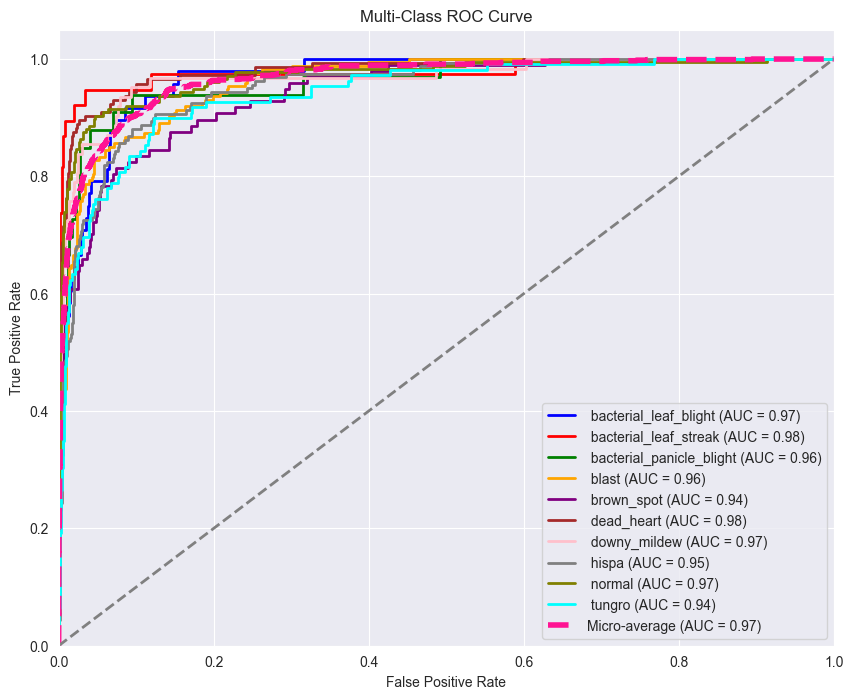

In [ ]:
# Binarize the true labels for multi-class ROC curve
y_true_bin = label_binarize(test_gen.classes, classes=np.arange(len(classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])

for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f' {classes[i]} (AUC = {roc_auc[i]:.2f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle='--', lw=4,
         label='Micro-average (AUC = {0:0.2f})'.format(roc_auc["micro"]))

# Plot diagonal line representing random guessing
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()


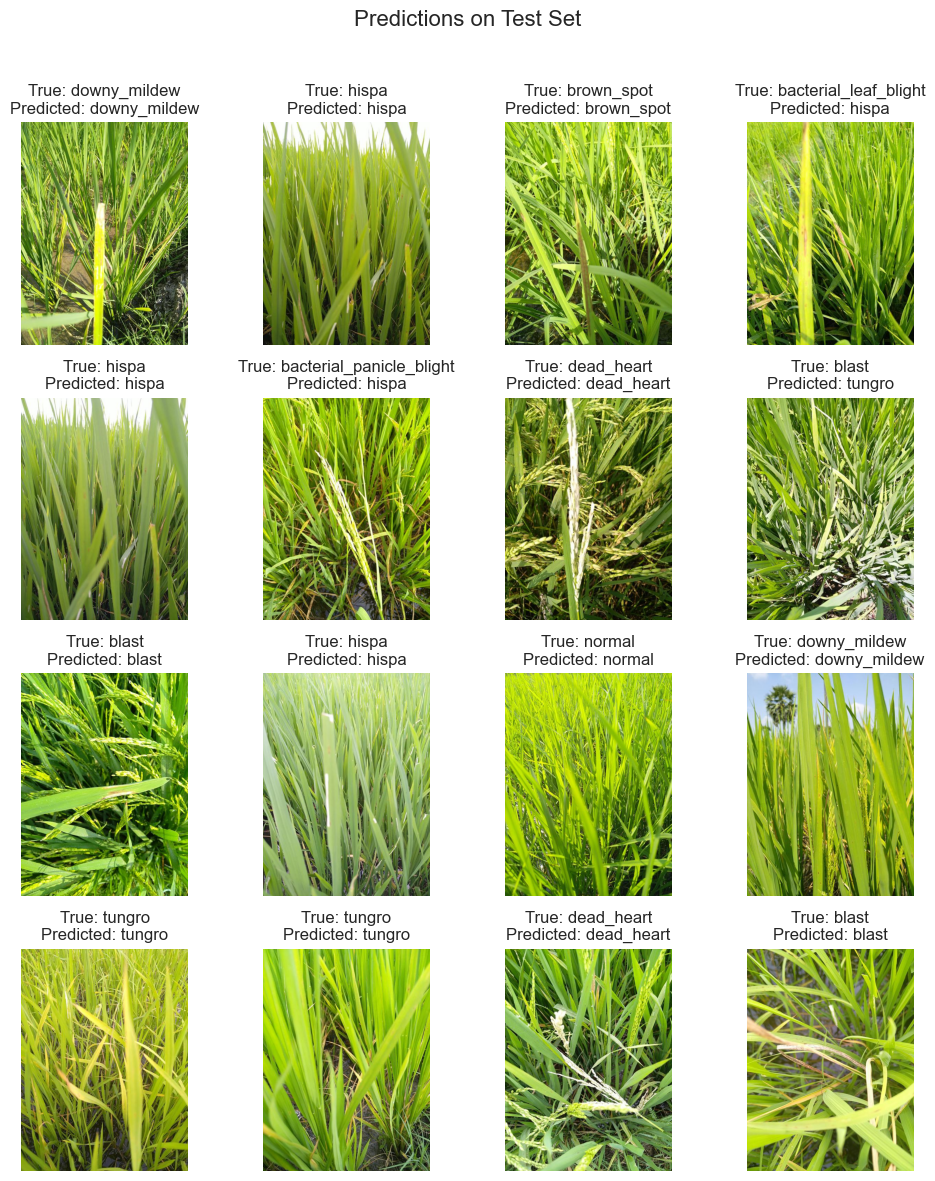

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Select 16 random indices from the test set
random_indices = np.random.choice(len(test_gen.filenames), size=16, replace=False)

# Get corresponding images, true labels, and predicted labels
selected_images = [test_gen.filepaths[i] for i in random_indices]
true_labels = [test_gen.classes[i] for i in random_indices]
predicted_labels = [y_pred[i] for i in random_indices]

# Create a grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(10, 12))
fig.suptitle('Predictions on Test Set', fontsize=16)

for i, (image_path, true_label, predicted_label) in enumerate(zip(selected_images, true_labels, predicted_labels)):
    # Load and display the image
    img = plt.imread(image_path)
    axes[i // 4, i % 4].imshow(img)
    axes[i // 4, i % 4].axis('off')

    # Set title with actual and predicted labels
    title = f'True: {classes[true_label]}\nPredicted: {classes[predicted_label]}'
    axes[i // 4, i % 4].set_title(title)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Save model

In [ ]:
# Extract model name from the input names
model_name = model.input_names[0][:-6]

# Specify subject and accuracy for naming the saved model
subject = 'paddy-disease'
acc = test_score[1] * 100

# Specify the save path (leave it empty if you want to save in the current directory)
save_path = ''

# Save the entire model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'Model was saved as {model_save_loc}')

# Save only the weights of the model
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'Weights were saved as {weights_save_loc}')


Model was saved as resnet101v2-paddy-disease-76.95.h5
Weights were saved as resnet101v2-paddy-disease-weights.h5


### Generate CSV files containing classes indicies & image size

{0: 'bacterial_leaf_blight', 1: 'bacterial_leaf_streak', 2: 'bacterial_panicle_blight', 3: 'blast', 4: 'brown_spot', 5: 'dead_heart', 6: 'downy_mildew', 7: 'hispa', 8: 'normal', 9: 'tungro'}


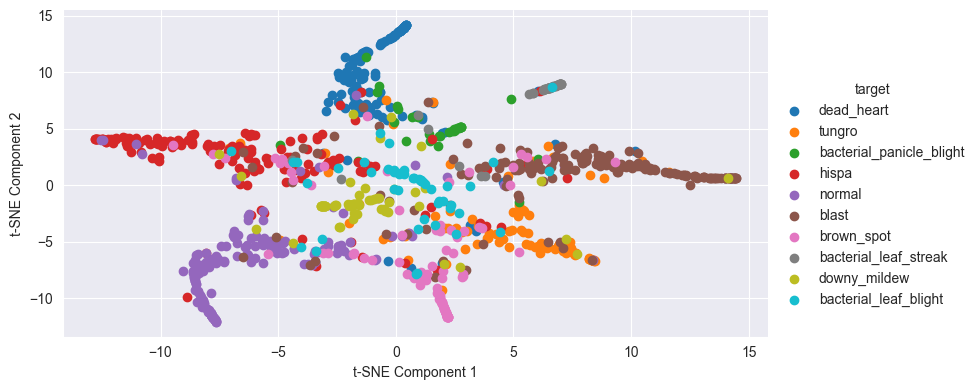

In [ ]:
# Create a dictionary mapping class indices to class names
target_name = {}
for index, value in enumerate(classes):
    target_name[index] = value
print(target_name)

# Apply t-SNE algorithm to reduce dimensionality to 2D
tsne_alg = TSNE(random_state=42, n_components=2, verbose=0, perplexity=40, n_iter=300).fit_transform(preds)

# Create a DataFrame for visualization
cps_df = pd.DataFrame(columns=['t-SNE Component 1', 't-SNE Component 2', 'target'],
                      data=np.column_stack((tsne_alg, test_gen.classes)))  # cast targets column to int
cps_df.loc[:, 'target'] = cps_df.target.astype(int)

# Map class indices to class names
cps_df.loc[:, 'target'] = cps_df.target.map(target_name)

# Create a scatter plot using seaborn's FacetGrid
grid = sns.FacetGrid(cps_df, hue="target", height=4, aspect=2)
grid.map(plt.scatter, 't-SNE Component 1', 't-SNE Component 2').add_legend()